In [1]:
import argparse
import os
import shutil
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import models
from dataset import CIFAR10C
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy import stats
import torch.nn.functional as F
from cautious_extrapolation.data_paths import DATA_PATHS


/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = torch.nn.DataParallel(models.resnet20(10))


/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 0 which
    has less than 75% of the memory or cores of GPU 1. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


In [3]:
checkpoint_name = "data/xent_seed0_2023_05_26_19_49_28/best.th"
checkpoint = torch.load(checkpoint_name)
model.load_state_dict(checkpoint['state_dict'])
model.cuda()
model.eval()

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       

In [4]:
corruption_type = "impulse_noise"
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

val_loaders = []

val_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root=DATA_PATHS["nfs"]["CIFAR10"], train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=128, shuffle=False,
    num_workers=4, pin_memory=True)
val_loaders.append(val_loader)

for corruption_level in range(5):
    valc_loader = torch.utils.data.DataLoader(
        CIFAR10C("nfs", corruption_type, corruption_level, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=128, shuffle=False,
        num_workers=4, pin_memory=True)
    val_loaders.append(valc_loader)


In [5]:
import numpy as np
from PIL import Image

def image_to_convolution_chunks(image, kernel_size, padding=0, stride=1):

    image = np.array(image)

    # Apply padding
    if padding > 0:
        image = np.pad(image, pad_width=( (0, 0),  (0, 0), (padding, padding), (padding, padding)), mode='constant', constant_values=0)

    # Calculate number of chunks
    chunks_x = (image.shape[-2] - kernel_size) // stride + 1
    chunks_y = (image.shape[-1] - kernel_size) // stride + 1

    # Initialize a list to store chunks
    chunks = []

    # Split the image into chunks
    for i in range(chunks_x):
        for j in range(chunks_y):
            chunk = image[:, :, i*stride:i*stride+kernel_size, j*stride:j*stride+kernel_size]
            chunks.append(chunk)

    chunks = np.array(chunks)
    
    # chunks = np.swapaxes(chunks, 0, 1)
    return chunks

In [6]:

module = model._modules.get('module')
w = module.layer3[0].conv1.weight.reshape(64, -1)

u, s, vh = np.linalg.svd(w.detach().cpu().numpy(), full_matrices=False)
cumulative_s_ratio = (np.cumsum(s**2)/np.sum(s**2))**0.5
num_components = np.where(np.array(cumulative_s_ratio) > 0.95)[0][0]


phis_all0 = {}
phis_all1 = {}
phis_all2 = {}
phis_all3 = {}
phis_all4 = {}
chucks_all3 = {}
chucks_p_all3 = {}
phis_all5 = {}



for i in range(len(val_loaders)):
    loader = val_loaders[i]
    phis0 = np.zeros((len(loader.dataset)))
    phis1 = np.zeros((len(loader.dataset)))
    phis2 = np.zeros((len(loader.dataset)))
    phis3 = np.zeros((len(loader.dataset)))
    phis4 = np.zeros((len(loader.dataset)))
    chunks3 = np.zeros((len(loader.dataset)*64))
    chunks_p3 = np.zeros((len(loader.dataset)*64))
    phis5 = np.zeros((len(loader.dataset)))

    for batch_idx, (x, target) in enumerate(loader):
        x, target = x.cuda().float(), target.cuda()
        phis0[batch_idx*128:(batch_idx+1)*128] = np.linalg.norm(x.detach().cpu().numpy().reshape((len(x), -1)), axis=1)

        out = module.conv1(x)
        phis1[batch_idx*128:(batch_idx+1)*128] = np.linalg.norm(out.detach().cpu().numpy().reshape((len(out), -1)), axis=1)
        out = F.relu(module.bn1(out))
        out = module.layer1(out)
        phis2[batch_idx*128:(batch_idx+1)*128] = np.linalg.norm(out.detach().cpu().numpy().reshape((len(out), -1)), axis=1)

        # print(out.shape)
        out = module.layer2(out)
        phis3[batch_idx*128:(batch_idx+1)*128] = np.linalg.norm(out.detach().cpu().numpy().reshape((len(out), -1)), axis=1)

        chucks_batch = image_to_convolution_chunks(out.cpu().detach().numpy(), 3, padding=1, stride=2)
        chucks_batch = np.reshape(chucks_batch, (-1, 32, 3, 3))
        chucks_batch = np.reshape(chucks_batch, (len(chucks_batch), -1))
        chunks3[batch_idx*128*64:(batch_idx+1)*128*64] =  np.linalg.norm(chucks_batch, axis=1)

        projected_chucks_batch= (chucks_batch@vh[:num_components].T)@vh[:num_components]
        projected_chucks_batch = (np.linalg.norm(projected_chucks_batch, axis=1))
        chunks_p3[batch_idx*128*64:(batch_idx+1)*128*64] = projected_chucks_batch

        # print(out.shape)

        out = module.layer3(out)
        phis4[batch_idx*128:(batch_idx+1)*128] = np.linalg.norm(out.detach().cpu().numpy().reshape((len(out), -1)), axis=1)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = module.linear(out) - module.linear.bias
        phis5[batch_idx*128:(batch_idx+1)*128] = np.linalg.norm(out.detach().cpu().numpy(), axis=1)
    
    phis_all0[i] = phis0
    phis_all1[i] = phis1
    phis_all2[i] = phis2
    phis_all3[i] = phis3
    phis_all4[i] = phis4
    chucks_all3[i] = chunks3
    chucks_p_all3[i] = chunks_p3
    phis_all5[i] = phis5

In [7]:
projected_ratio_means = []
projected_ratio_stds = []
projected_ratio_all = []
for i in range(len(val_loaders)):
    projected_ratio = (chucks_p_all3[i]**2/chucks_all3[i]**2)
    projected_ratio_all.append(projected_ratio)
    projected_ratio_means.append(np.mean(projected_ratio))
    projected_ratio_stds.append(np.std(projected_ratio))


In [12]:
x = torch.zeros((1, 64)).cuda()
x = module.linear(x)
zero_input_output = F.softmax(x, dim=1)
zero_input_output = zero_input_output.detach().cpu().numpy()[0]

In [13]:
model = torch.nn.DataParallel(models.resnet20(11))
checkpoint_name = "data/reward_prediction_seed1_2023_05_26_19_52_26/best.th"
checkpoint = torch.load(checkpoint_name)
model.load_state_dict(checkpoint['state_dict'])
model.cuda()
model.eval()

module = model._modules.get('module')

x = torch.zeros((1, 64, 8, 8)).cuda()
x = module.layer3[1](x)
x = module.layer3[2](x)
x = F.avg_pool2d(x, x.size()[3])
x = x.view(x.size(0), -1)
zero_input_output_mse = module.linear(x).detach().cpu().numpy()[0]

/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 0 which
    has less than 75% of the memory or cores of GPU 1. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  


[1.         1.21059982 1.19346711 0.99637386 0.63620552 0.56443818]
[1.         1.15501231 1.13588778 1.00481409 0.6844591  0.5658804 ]
[1.         1.09639359 1.07603762 1.02188426 0.77561693 0.63697101]
[1.         1.06562341 1.04718794 1.02937685 0.83725271 0.71409738]
[1.         1.03344473 1.02066624 1.0285392  0.90683324 0.8226313 ]


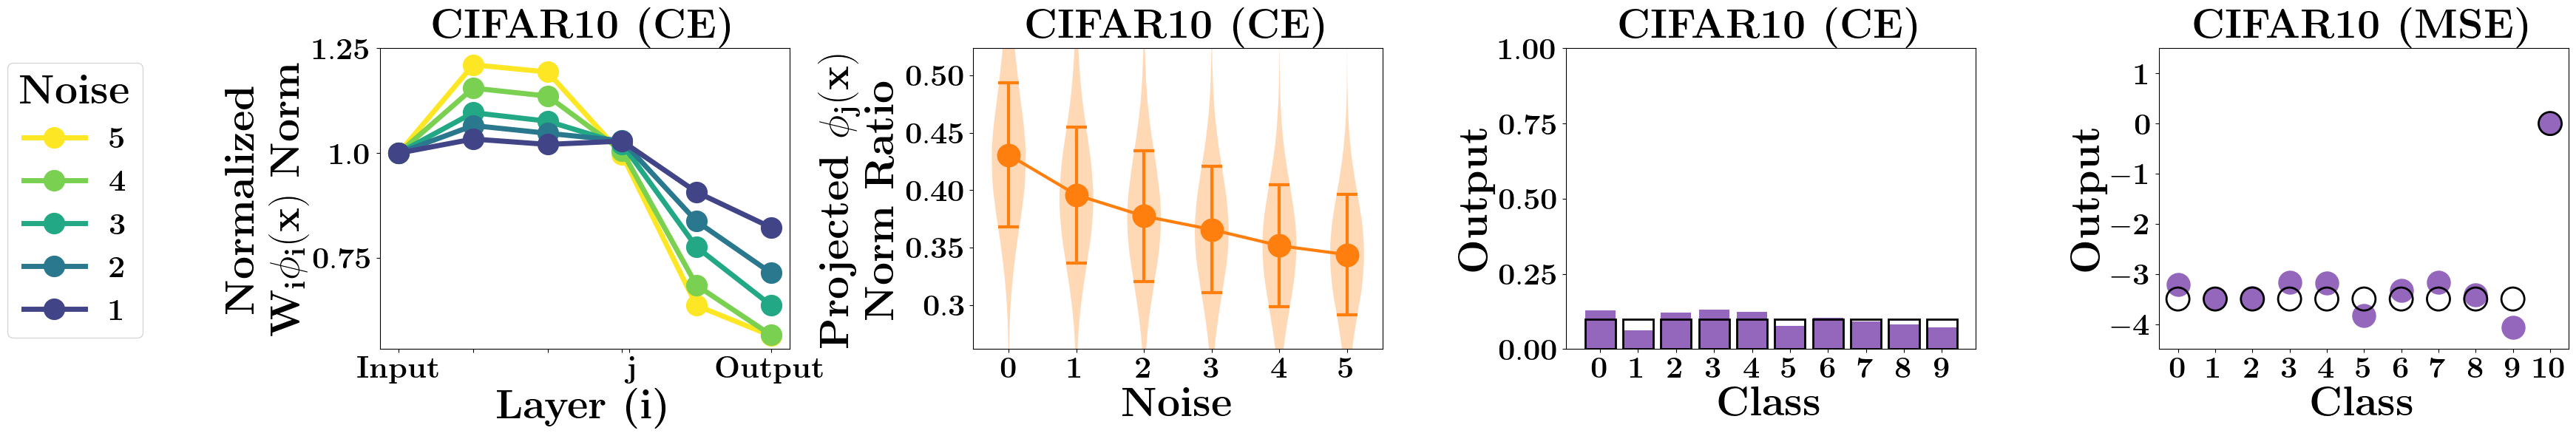

In [42]:
import matplotlib as mpl
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\boldmath']

from matplotlib import cm
fig, axs = plt.subplots(1, 4, figsize=(35, 6))

viridis = cm.get_cmap('viridis', 6)
colors = viridis(range(6))

zero_rotation_norms = [phis_all0[(0)].mean(),
                        phis_all1[(0)].mean(), 
                       phis_all2[(0)].mean(),
                          phis_all3[(0)].mean(),
                            phis_all4[(0)].mean(),
                          phis_all5[(0)].mean(),]
zero_rotation_norms = np.array(zero_rotation_norms)

for noise_level in range(5, 0, -1):
    ratios = [phis_all0[(0)].mean(),
        phis_all1[(noise_level)].mean(), 
                       phis_all2[(noise_level)].mean(),
                            phis_all3[(noise_level)].mean(),
                            phis_all4[(noise_level)].mean(),
                            phis_all5[(noise_level)].mean(),]
    ratios = np.array(ratios)
    ratios = ratios/zero_rotation_norms
    print(ratios)
    axs[0].plot([0, 1, 2, 3, 4, 5], ratios,  "o-", linewidth=5, markersize=20, c=colors[noise_level], label=r"$\mathbf{"+str(noise_level)+"}$",)#, c="C2", alpha=1-rotation_level/10)
    # 

axs[0].set_xticks([0, 1, 2, 3, 3.1, 5], [r"\textbf{Input}", "", "", "", r"$\mathbf{j}$", r"\textbf{Output}"])
axs[0].set_yticks([0.75, 1, 1.25], [r"$\mathbf{"+str(_)+"}$" for _ in [0.75, 1.00, 1.25]])
axs[0].tick_params(axis='both', which='major', labelsize=30)
axs[0].set_xlabel(r"\textbf{Layer (i)}", fontsize=40)
axs[0].set_ylabel(r"\textbf{Normalized"+"\n"+r"$\mathbf{W_i \phi_i(x)}$"+r"\textbf{ Norm}", fontsize=40)
axs[0].set_title(r"\textbf{CIFAR10 (CE)}", fontsize=40)

violin_parts = axs[1].violinplot(projected_ratio_all, showextrema=False, positions=[i for i in range(6)])
for vp in violin_parts['bodies']:
    vp.set_facecolor("C1")
axs[1].errorbar([i for i in range(6)], projected_ratio_means, yerr=projected_ratio_stds, c="C1", marker="o", linewidth=3, markersize=20, capsize=10, markeredgewidth=3)
axs[1].set_xlabel(r"\textbf{Noise}", fontsize=40)
axs[1].set_ylabel(r"\textbf{Projected }"+r"$\mathbf{\phi_j(x)}$"+"\n"+r"\textbf{Norm Ratio}", fontsize=40)
axs[1].set_xticks([i for i in range(6)], [r"\textbf{"+str(i)+"}" for i in range(6)], fontsize=30)
axs[1].set_yticks([0.3, 0.35, 0.40, 0.45, 0.50], [r"$\mathbf{0.3}$", r"$\mathbf{0.35}$", r"$\mathbf{0.40}$", r"$\mathbf{0.45}$", r"$\mathbf{0.50}$"], fontsize=30)
axs[1].set_ylim(np.min(np.array(projected_ratio_means)-np.array(projected_ratio_stds))-0.03, np.max(np.array(projected_ratio_means)+np.array(projected_ratio_stds))+0.03)
axs[1].tick_params(axis='both', which='major', labelsize=30)
axs[1].set_title(r"\textbf{CIFAR10 (CE)}", fontsize=40)

axs[2].bar([_ for _ in range(10)], zero_input_output, color="C4")#, label = r"\textbf{Model Constants}")
axs[2].bar([_ for _ in range(10)], [0.1 for _ in range(10)], color="none", edgecolor='black', linewidth=2)#, label = r"\textbf{OCS}")
# axs[2].legend(fontsize=20, loc='upper left')

axs[2].set_ylim(0, 1)
axs[2].set_xticks([_ for _ in range(10)], [r"$\mathbf{"+str(_)+"}$" for _ in range(10)])
axs[2].set_yticks([0.00, 0.25, 0.50, 0.75, 1.00], [r"$\mathbf{0.00}$", r"$\mathbf{0.25}$", r"$\mathbf{0.50}$", r"$\mathbf{0.75}$", r"$\mathbf{1.00}$"])
axs[2].tick_params(axis='both', which='major', labelsize=30)
axs[2].set_xlabel(r"\textbf{Class}", fontsize=40)
# axs[2].set_ylabel(r"\textbf{softmax(}"+"$\mathbf{g_{k+1}(\sigma(b_k))}$"+r"\textbf{)", fontsize=40)
axs[2].set_ylabel(r"\textbf{Output}", fontsize=40)
axs[2].set_title(r"\textbf{CIFAR10 (CE)}", fontsize=40)

axs[3].scatter([_ for _ in range(11)], zero_input_output_mse, color="C4", s=500)#, label = r"\textbf{Model Constants}")
axs[3].scatter([_ for _ in range(11)], [-3.5 for _ in range(10)]+[0], color="none", edgecolor='black', s=500, linewidth=2) #, label = r"\textbf{OCS}"
# axs[3].legend(fontsize=20, loc='upper left')

axs[3].set_ylim(-4.5, 1.5)
axs[3].set_xticks([_ for _ in range(11)], [r"$\mathbf{"+str(_)+"}$" for _ in range(11)])
axs[3].set_yticks([-4, -3, -2, -1, 0, 1], [r"$\mathbf{-4}$", r"$\mathbf{-3}$", r"$\mathbf{-2}$", r"$\mathbf{-1}$", r"$\mathbf{0}$", r"$\mathbf{1}$"])
axs[3].tick_params(axis='both', which='major', labelsize=30)
axs[3].set_xlabel(r"\textbf{Class}", fontsize=40)
# axs[3].set_ylabel(r"\textbf{softmax(}"+"$\mathbf{g_{k+1}(\sigma(b_k))}$"+r"\textbf{)", fontsize=40)
axs[3].set_ylabel(r"\textbf{Output}", fontsize=40)
axs[3].set_title(r"\textbf{CIFAR10 (MSE)}", fontsize=40)


fig.tight_layout()

fig.subplots_adjust(left=0.15)
fig.legend(title=r"\textbf{Noise}", loc='center left', bbox_to_anchor=(0, 0.54), fontsize=30, title_fontsize=40)